<a href="https://colab.research.google.com/github/shravankumargulvadi/Modified-One-Cycle-Learning-Rate/blob/master/Custom_one_cycle_LR_Implementation_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install keras-lr-finder keras

In [0]:

import argparse
import logging

import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model
import keras.backend as K
from keras.datasets import cifar10
import numpy as np
import os

from keras_lr_finder import LRFinder

logging.basicConfig(level=logging.INFO)
np.random.seed(5)

# Training parameters
batch_size = 512  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = True
num_classes = 10
n = 3
depth = n * 6 + 2
weightDecay=0.0001
logging.info(f'Running experiment with following training parameters:\n  batch_size:{batch_size}\n'
             f' epochs:{epochs}\n   data_augmentation:\n        -Add 4 pixel padding and random crop by 32,32'
             f'\n       -Horizontal flip\n  weigthDecay:{weightDecay}\n    NormalizeData:True\n'
             f' StandardiseData:True')

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, 1)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]
print(input_shape)
print(x_train.shape)

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
model.summary()

170500096/170498071 [==============================] - 11s 0us/step
(32, 32, 3)
(50000, 32, 32, 3)


W0812 12:26:31.103012 140534463129472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 12:26:31.137866 140534463129472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 12:26:31.146512 140534463129472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0812 12:26:31.202958 140534463129472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0812 12:26:31.204407

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


W0812 12:26:34.903277 140534463129472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0812 12:26:37.051344 140534463129472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0812 12:26:37.083058 140534463129472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

W0812 12:27:20.941289 140534463129472 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
50000/50000 [==============================] - 31s 618us/step - loss: 3.5920 - acc: 0.1498
ma_lr=
0.041825406


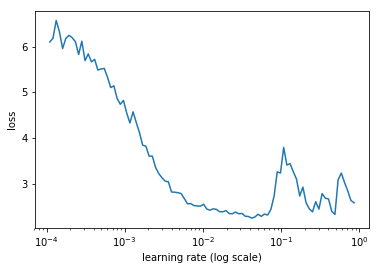

In [0]:
# LR finder
# model is a Keras model
lr_finder = LRFinder(model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(x_train, y_train, start_lr=0.0001, end_lr=1, batch_size=512, epochs=1)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)
print('ma_lr=')
print(lr_finder.lrs[np.argmin(lr_finder.losses)])
model.save_weights('lr experiments')

In [0]:
def cutout(img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        n_holes=1
        length=8
        img= np.array(img)
        h = img.shape[0]
        w = img.shape[1]
        

        mask = np.ones((h, w, 3), np.float32)

        for n in range(n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = int(np.clip(y - length // 2, 0, h))
            y2 = int(np.clip(y + length // 2, 0, h))
            x1 = int(np.clip(x - length // 2, 0, w))
            x2 = int(np.clip(x + length // 2, 0, w))

            mask[y1: y2, x1: x2] = 0.
            #print(mask, img.shape, y, x )
       
        img = img * mask
        return img

In [0]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *
import keras
import numpy as np


class CustomOnecycle(keras.callbacks.Callback):
   def __init__(self,max_lr,min_lr,epoch_peak,batch_size,epoch,train_size):
 
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.epoch_peak = epoch_peak
        self.train_size=train_size
        self.batch_size=batch_size
        self.peak_iteration=int((self.epoch_peak*(train_size/batch_size)))
        self.max_iteration=epoch*(train_size/batch_size)
        self.clr_iterations=0
        self.lrlist=[]
        self.batchlist=[]
        
   
   def clr(self, i):
       print()
       self.batchlist.append(i)
   
       if i <self.peak_iteration:
          lr=(i*((self.max_lr-self.min_lr)/(self.peak_iteration-1)))+self.min_lr
          
       else:
          lr=((i-self.peak_iteration)*((self.min_lr-self.max_lr)/(self.max_iteration-self.peak_iteration)))+self.max_lr
         
       return lr
      
    
        
  
   def on_batch_begin(self, batch, logs=None):
        
        
        logs = logs or {}
     
        self.clr_iterations += 1
        lr=self.clr(self.clr_iterations)
        self.lrlist.append(lr)
        print(lr)

        
       
        K.set_value(self.model.optimizer.lr, lr)
        

In [0]:
model_1 = resnet_v1(input_shape=input_shape, depth=depth)
from keras.optimizers import Adam, SGD
model_1.load_weights('lr experiments')
model_1.compile(loss='categorical_crossentropy',
              optimizer=SGD(decay=0.001),
              metrics=['accuracy'])
model_1.summary()

max_lr=0.7
min_lr=max_lr/10
epoch_peak=7
epochs=24
batch_size=512

clr=CustomOnecycle(max_lr=max_lr,min_lr=min_lr,epoch_peak=epoch_peak,batch_size=batch_size,epoch=epochs,train_size=50000)



callbacks = [clr, ModelCheckpoint(filepath='best_model.h5', monitor='val_acc',mode='max',verbose=1,save_best_only=True)]


from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False, preprocessing_function=cutout)
# train the model
start = time.time()
# Train the model
model_info = model_1.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), samples_per_epoch = y_train.shape[0], nb_epoch = epochs, validation_data = (x_test, y_test), verbose=1, callbacks=callbacks)
end = time.time()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_673 (Conv2D)             (None, 32, 32, 16)   448         input_33[0][0]                   
__________________________________________________________________________________________________
batch_normalization_609 (BatchN (None, 32, 32, 16)   64          conv2d_673[0][0]                 
__________________________________________________________________________________________________
activation_609 (Activation)     (None, 32, 32, 16)   0           batch_normalization_609[0][0]    
__________________________________________________________________________________________________
conv2d_674

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., steps_per_epoch=97, epochs=24)`


Epoch 1/24

1
0.07092375366568915
 1/97 [..............................] - ETA: 41:15 - loss: 6.5009 - acc: 0.0938
2
0.07184750733137829


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:99: UserWarning: Method on_batch_begin() is slow compared to the batch update (10.581204). Check your callbacks.
  % delta_t_median)


 2/97 [..............................] - ETA: 20:39 - loss: 5.2376 - acc: 0.1162
3
0.07277126099706745
 3/97 [..............................] - ETA: 13:46 - loss: 4.8764 - acc: 0.1081
4
0.07369501466275659
 4/97 [>.............................] - ETA: 10:19 - loss: 4.5068 - acc: 0.1167
5
0.07461876832844574
 5/97 [>.............................] - ETA: 8:14 - loss: 4.2496 - acc: 0.1168 
6
0.07554252199413489
 6/97 [>.............................] - ETA: 6:52 - loss: 4.0380 - acc: 0.1257
7
0.07646627565982404
 7/97 [=>............................] - ETA: 5:52 - loss: 3.8268 - acc: 0.1384
8
0.07739002932551318
 8/97 [=>............................] - ETA: 5:08 - loss: 3.6766 - acc: 0.1455
9
0.07831378299120234
 9/97 [=>............................] - ETA: 4:33 - loss: 3.5712 - acc: 0.1480
10
0.07923753665689148
10/97 [==>...........................] - ETA: 4:05 - loss: 3.4749 - acc: 0.1521
11
0.08016129032258064
11/97 [==>...........................] - ETA: 3:42 - loss: 3.3928 - acc: 0.1